In [1]:
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import Sequential
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from torch.optim import Adam
from sklearn.metrics import accuracy_score, roc_auc_score
from torch import nn
from sklearn.decomposition import PCA
import copy

In [2]:
def plot_corr_matrix(data):
    corr_matrix = data.corr().abs()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Матрица корреляции")
    plt.show()


def find_corr_pair(data):
    corr_matrix = data.corr().abs()
    corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)] = 0  # Обнуляем верхний треугольник
    corr_pairs = corr_matrix.stack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]
    corr_pairs = corr_pairs[corr_pairs['Correlation'] > 0].sort_values(by='Correlation', ascending=False)
    return corr_pairs

def convert_data_to_tensor(x_train_, x_valid_, y_train_, y_valid_):
    return (torch.FloatTensor(x_train_.values), 
            torch.FloatTensor(x_valid_.values), 
            torch.LongTensor(y_train_.values), 
            torch.LongTensor(y_valid_.values))


def fit_predict(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)  #best: 0.8410852713178295 # 0.8527131782945736
    print(accuracy_score(y_valid, y_pred))


def fit_predict_torch(model, x_train_, y_train_, x_valid_, y_valid_, epochs=500, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    best_valid_acc, best_epoch = 0., 1
    best_weights = None
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_.to(device))
        loss = criterion(outputs, y_train_.float().to(device))
        loss.backward()
        optimizer.step()

        train_acc = accuracy_score(y_train_.cpu(), (outputs > 0.5).int().cpu())

        model.eval()
        with torch.no_grad():
            valid_outputs = model(x_valid_.to(device))
            valid_loss = criterion(valid_outputs, y_valid_.float().to(device))
            valid_acc = accuracy_score(y_valid_.cpu(), (valid_outputs > 0.5).int().cpu())
            auc = roc_auc_score(y_valid_.cpu(), valid_outputs.cpu().numpy())
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                best_epoch = epoch + 1
                best_weights = copy.deepcopy(model.state_dict())
        print(
            f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_acc:.4f}, Test Loss: {valid_loss.item():.4f}, Accuracy: {valid_acc:.4f}, AUC: {auc:.4f}')
    print("Best accuracy:", best_valid_acc, "epoch:", best_epoch)
    return best_weights, best_valid_acc

# Загрузка данных

In [17]:
train_data = pd.read_csv('data/full_data.csv')
test_data = pd.read_csv('data/test_with_targets.csv')
train_data

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,63391,1568.4050,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,1
1,68358,1942.1870,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,1
2,73589,1246.5380,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,1
3,71106,1445.2610,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,1
4,80087,1251.5240,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,85983,1157.1160,444.3447,248.8627,0.8284,330.8730,0.9823,87536,0.6799,1.7855,0.8070,0.7446,0.0052,0.0029,0.5545,0.9900,0
2144,85691,2327.3459,439.8794,278.9297,0.7732,330.3107,0.8886,96439,0.6590,1.5770,0.1988,0.7509,0.0051,0.0033,0.5639,0.8892,0
2145,101136,1255.6190,475.2161,271.3299,0.8210,358.8459,0.9888,102286,0.7584,1.7514,0.8061,0.7551,0.0047,0.0027,0.5702,0.9987,0
2146,97409,1195.2150,452.1823,274.5764,0.7945,352.1718,0.9902,98376,0.7635,1.6468,0.8569,0.7788,0.0046,0.0028,0.6066,0.9989,0


In [18]:
def plot_distribution(data, axis, columnsm ):
    fig, ax = plt.subplots(axis, columnsm, figsize=(15, 15))
    idx = 0
    
    for i in range(axis):
        for j in range(columnsm):
            if idx < len(data.columns) - 1:
                column = data.drop(columns='target').columns[idx]
                sns.kdeplot(data=data, x=column, hue='target', ax=ax[i][j], fill=True)
                ax[i][j].set_title(f'{column} Distribution')
                idx += 1
    
    fig.suptitle('Feature Distribution', fontsize=24, y=0.99)
    plt.tight_layout()
    plt.show()

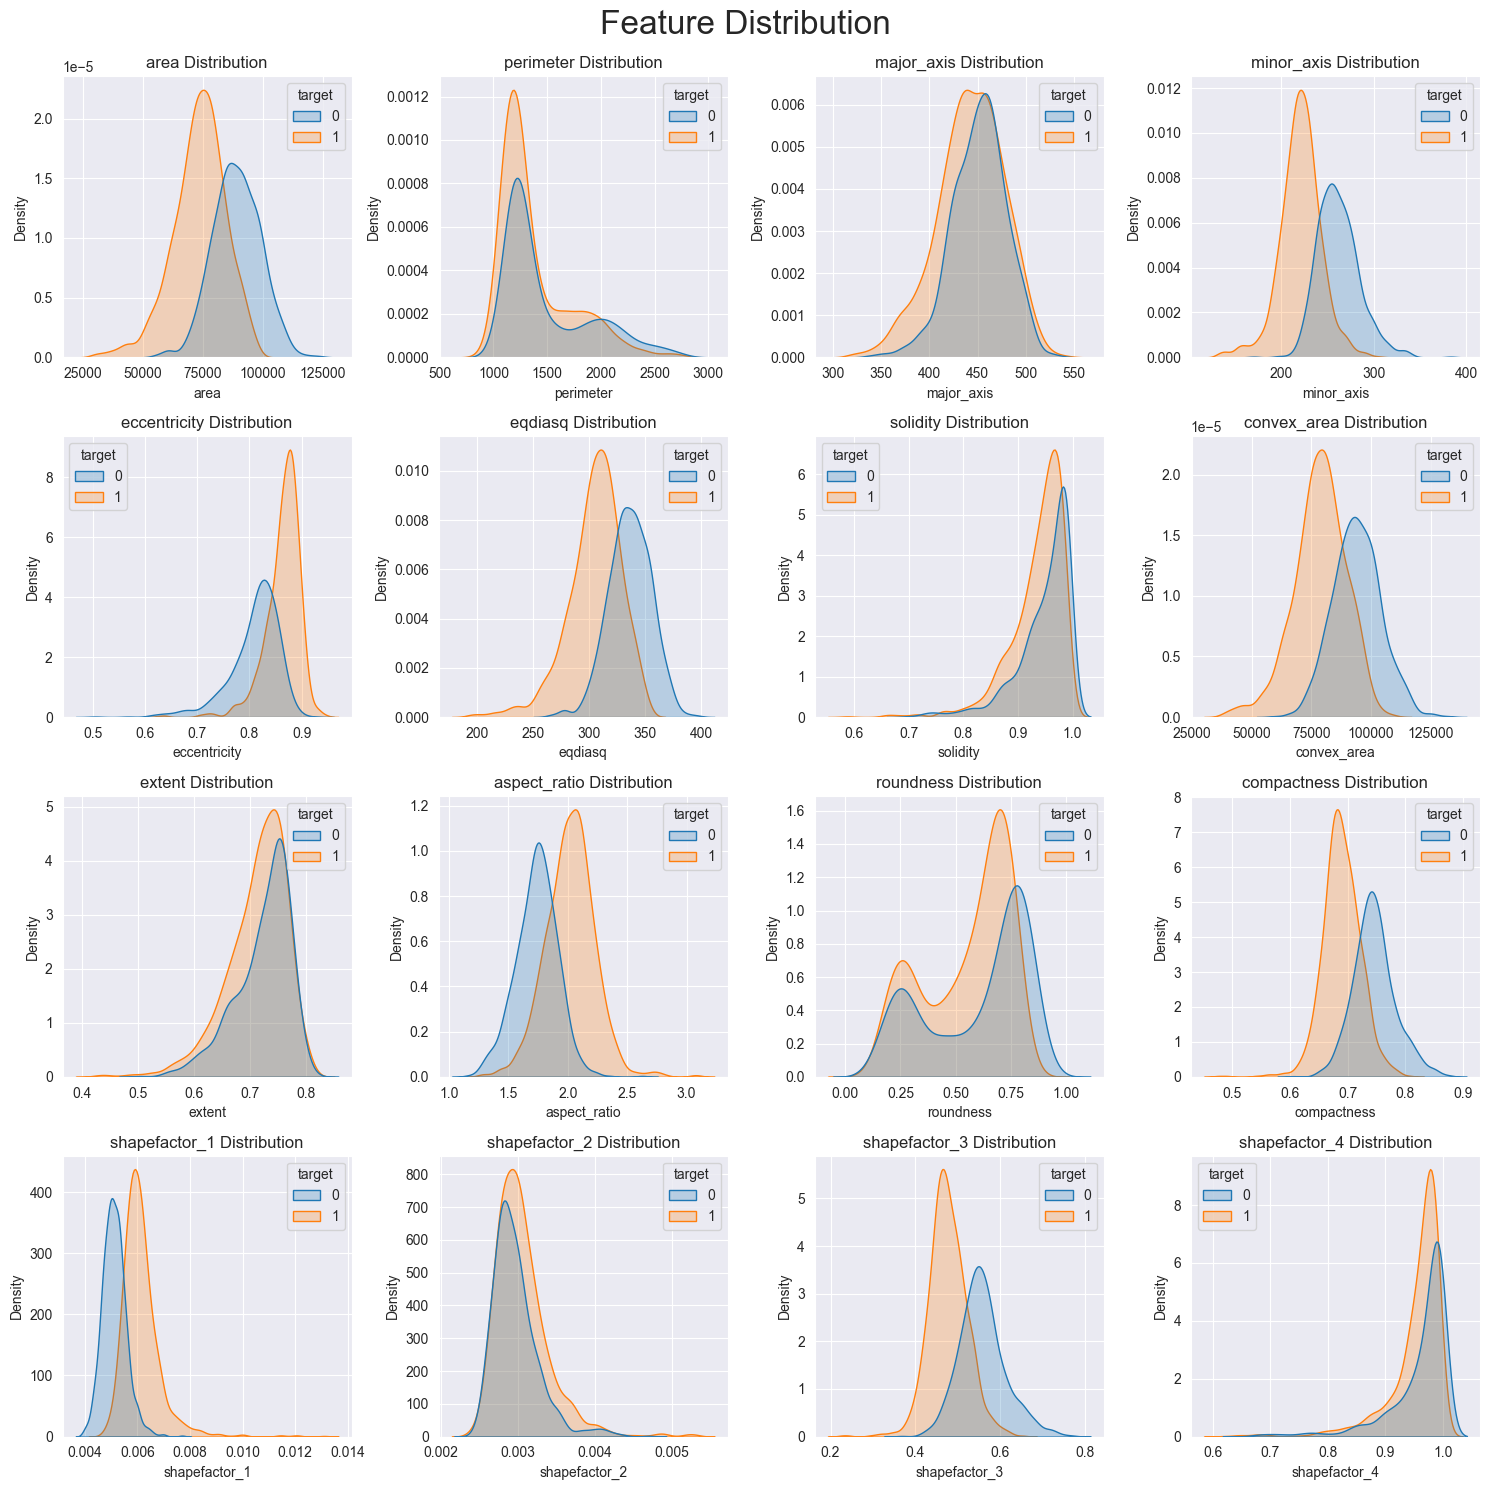

In [19]:
plot_distribution(train_data, 4, 4)

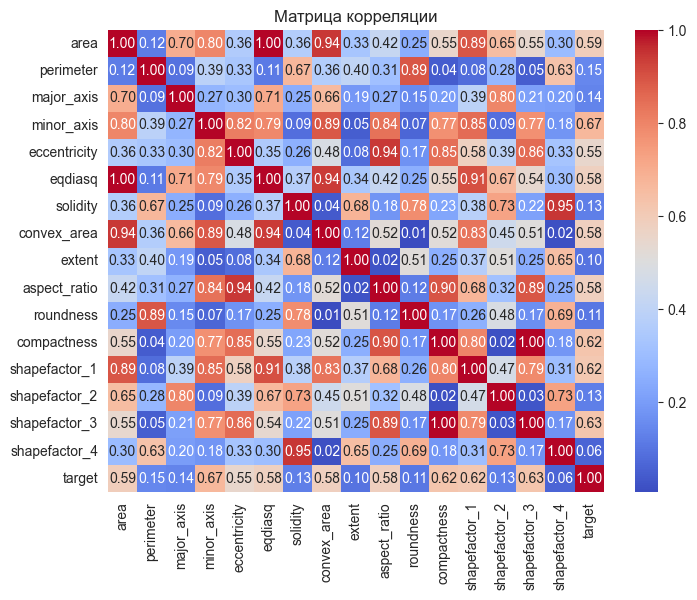

,Feature1,Feature2,Correlation
249,shapefactor_3,compactness,0.998625
85,eqdiasq,area,0.997399
261,shapefactor_4,solidity,0.949501
119,convex_area,area,0.943877
157,aspect_ratio,eccentricity,0.943751
...,...,...,...
251,shapefactor_3,shapefactor_2,0.027550
161,aspect_ratio,extent,0.023303
262,shapefactor_4,convex_area,0.017052
232,shapefactor_2,compactness,0.016562


In [20]:
plot_corr_matrix(train_data)
find_corr_pair(train_data)

# Преобразование данных

In [21]:
def transform_data(data):
    transformed_data = data.copy()
    # transformed_data["area"] = transformed_data[['area', 'convex_area', "eqdiasq"]].mean(axis=1)
    # transformed_data["shapefactor_3"] = transformed_data[['shapefactor_3', 'compactness']].mean(axis=1)
    # transformed_data["shapefactor_4"] = transformed_data[['shapefactor_4', 'solidity']].mean(axis=1)
    # # transformed_data["eccentricity_+_aspect_ratio"] = PCA(n_components=1).fit_transform(transformed_data[['eccentricity', "aspect_ratio"]])
    # 
    # transformed_data["shapefactor_3"] = transformed_data[['eccentricity', 'shapefactor_3', "aspect_ratio"]].mean(axis=1)
    # 
    # transformed_data.drop(['convex_area', "eqdiasq", "compactness", "solidity", 'eccentricity', "aspect_ratio"], axis=1, inplace=True)
    # 
    # transformed_data.drop(["perimeter", "major_axis", "solidity", "extent", "roundness", "shapefactor_2", "shapefactor_4"], axis=1, inplace=True)
    # 
    # transformed_data["area"] = transformed_data[['area', 'convex_area', "eqdiasq", "minor_axis"]].mean(axis=1)
    # transformed_data.drop(['convex_area', "eqdiasq", "minor_axis"], axis=1, inplace=True)

    # transformed_data["shapefactor_3"] = transformed_data["shapefactor_3"]
    # transformed_data.drop(["eqdiasq"], axis=1, inplace=True)
    
    #=======================[ через PCA ]==========================
    n = 6
    transformed_data = pd.DataFrame(PCA(n_components=n).fit_transform(transformed_data.drop("target", axis=1)), columns=[f"feature_{i+1}" for i in range(n)])
    transformed_data["target"] = data["target"]
    return transformed_data

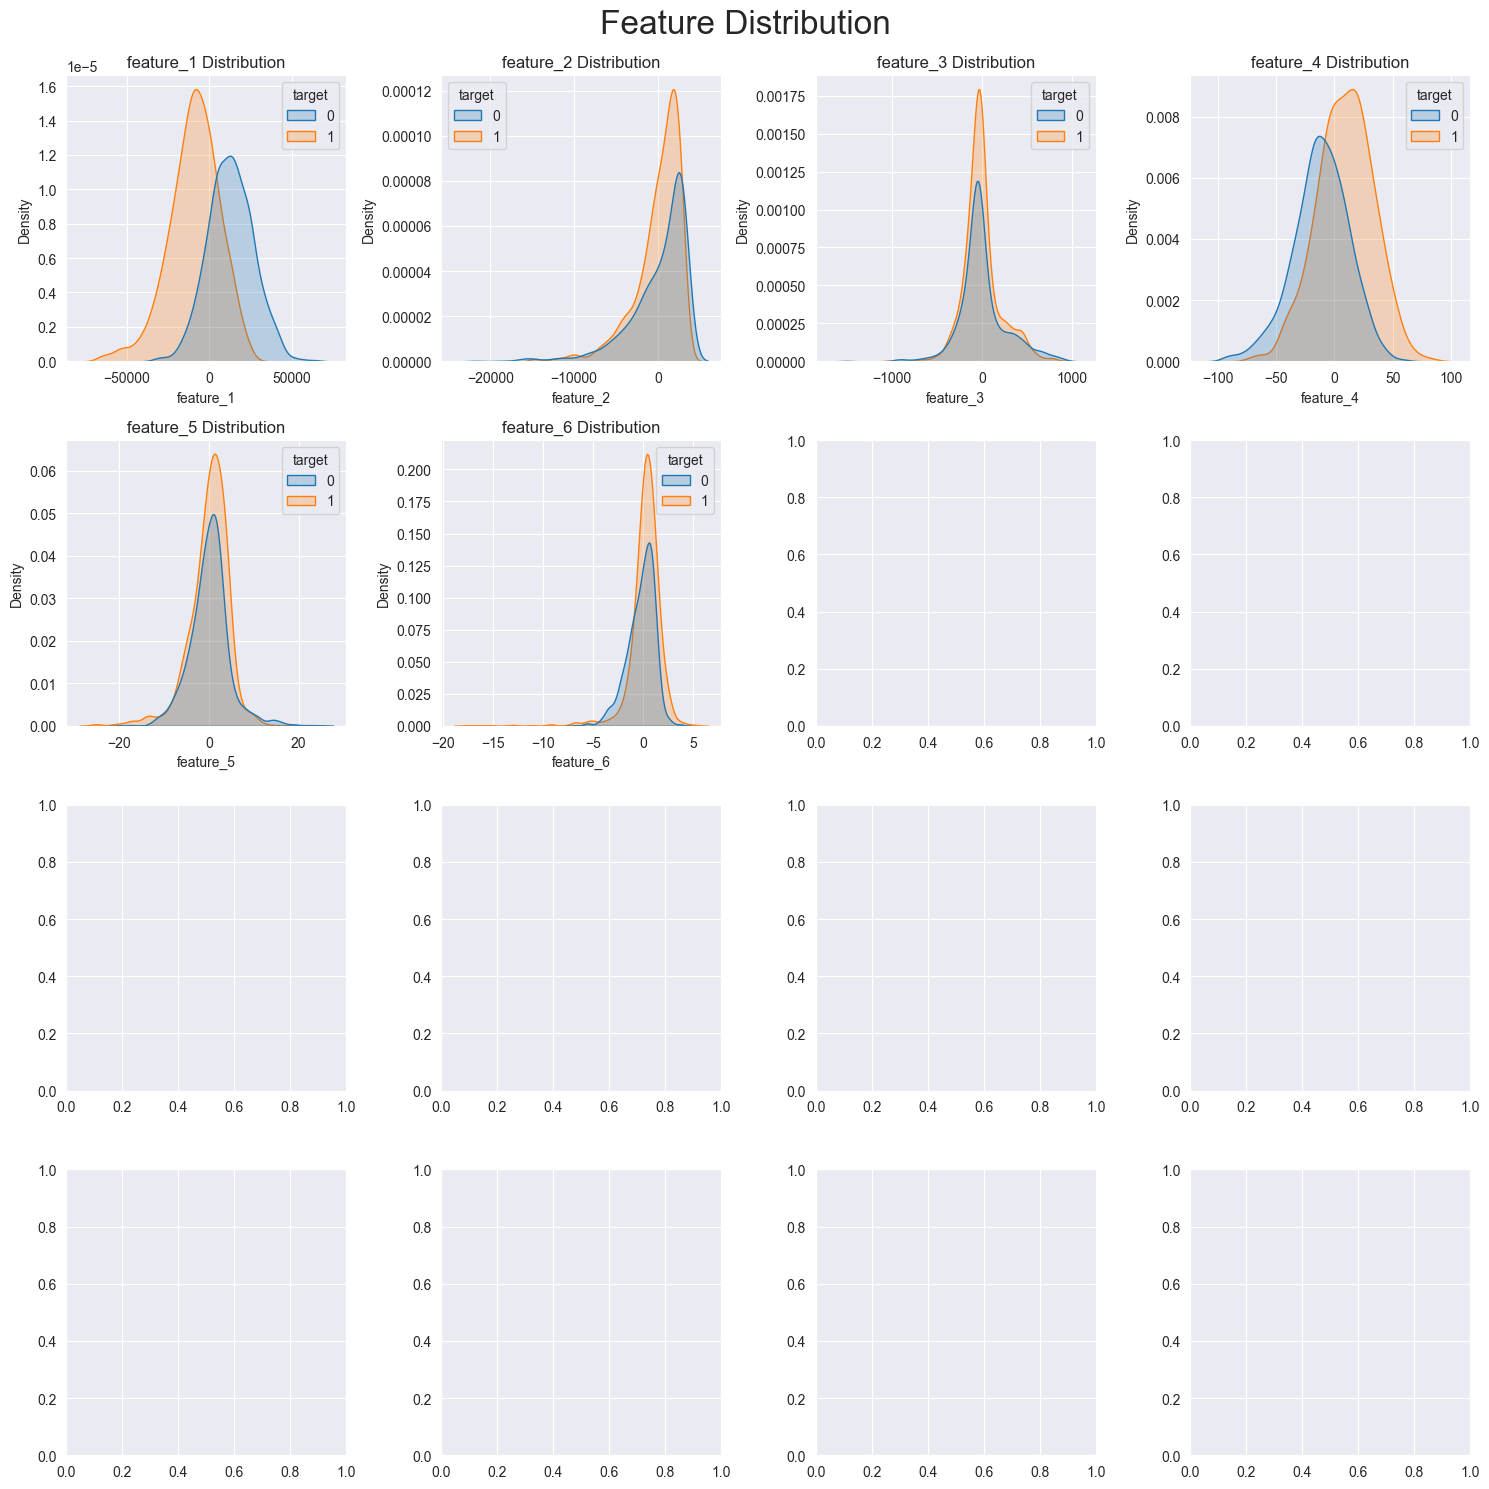

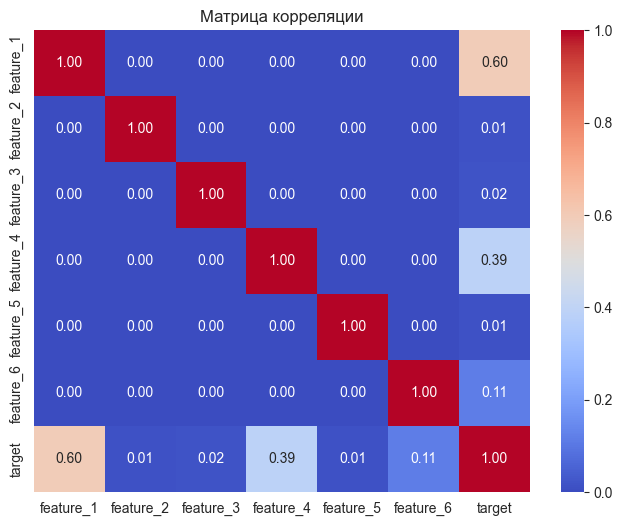

,Feature1,Feature2,Correlation
42,target,feature_1,5.953284e-01
45,target,feature_4,3.882620e-01
47,target,feature_6,1.144780e-01
44,target,feature_3,1.659119e-02
43,target,feature_2,1.394412e-02
46,target,feature_5,1.353378e-02
39,feature_6,feature_5,9.041713e-13
36,feature_6,feature_2,6.795078e-13
37,feature_6,feature_3,6.200589e-13
35,feature_6,feature_1,3.096746e-13


In [22]:
transformed_train_data = transform_data(train_data)
transformed_test_data = transform_data(test_data)
plot_distribution(transformed_train_data, 4, 4)
plot_corr_matrix(transformed_train_data)
find_corr_pair(transformed_train_data)

# Делим на тест и валид

In [23]:
x_train = transformed_train_data.drop(labels=["target"], axis=1)
y_train = transformed_train_data["target"]
x_valid = transformed_test_data.drop(labels=["target"], axis=1)
y_valid = transformed_test_data["target"]

# Модели

In [34]:
forest = RandomForestClassifier(max_depth=12, random_state=2, n_estimators=10, class_weight='balanced')
catboost = CatBoostClassifier(
    iterations=500,       # Количество деревьев
    learning_rate=0.01,    # Скорость обучения
    depth=4,             # Глубина деревьев
    loss_function='Logloss',  # Функция потерь для бинарной классификации
    eval_metric='Accuracy',   # Метрика для валидации
    verbose=50,          # Вывод лога каждые 50 итераций
    random_state=1
)
fit_predict(forest)
fit_predict(catboost)

0.9418604651162791
0:	learn: 0.8179702	total: 1.33ms	remaining: 664ms
50:	learn: 0.8561453	total: 51.5ms	remaining: 453ms
100:	learn: 0.8631285	total: 90.4ms	remaining: 357ms
150:	learn: 0.8696462	total: 130ms	remaining: 301ms
200:	learn: 0.8752328	total: 169ms	remaining: 252ms
250:	learn: 0.8798883	total: 209ms	remaining: 208ms
300:	learn: 0.8822160	total: 249ms	remaining: 165ms
350:	learn: 0.8864060	total: 293ms	remaining: 125ms
400:	learn: 0.8887337	total: 337ms	remaining: 83.1ms
450:	learn: 0.8901304	total: 383ms	remaining: 41.6ms
499:	learn: 0.8910615	total: 426ms	remaining: 0us
0.9232558139534883


In [42]:
y_pred = forest.predict(x_valid)
print(accuracy_score(y_valid, y_pred))

0.9418604651162791


In [43]:
pd.DataFrame(y_pred).to_csv('ans.csv', index=False, header=False)

In [11]:
forest.feature_importances_ * 100

array([42.77932581, 11.19345135,  7.13988496, 21.12147555,  8.924644  ,
        8.84121833])

In [25]:
best_acc, best_weights = 0, None

In [26]:
class MyModel(nn.Module):
    def __init__(self, input: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input, 16), 
            nn.BatchNorm1d(16),
            nn.Sigmoid(),
            
            # nn.Linear(16, 32), 
            # nn.BatchNorm1d(32),
            # nn.Sigmoid(),
            # nn.Dropout(0.1),
            # 
            # nn.Linear(32, 16),    
            # nn.BatchNorm1d(16),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(16, 1),
            nn.BatchNorm1d(1),  
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.layers.forward(x).squeeze()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_model = MyModel(len(x_train.columns)).to(device)
torch_train_x, torch_valid_x, torch_train_y, torch_valid_y = convert_data_to_tensor(x_train, x_valid, y_train, y_valid)

weights, accuracy = fit_predict_torch(torch_model, torch_train_x, torch_train_y, torch_valid_x, torch_valid_y, epochs=2000,  lr=0.105)
if accuracy > best_acc:
    best_acc = accuracy
    best_weights = copy.deepcopy(weights)
print("all time best accuracy:", best_acc)

Epoch 1/2000, Loss: 0.5143, Accuracy: 0.7630, Test Loss: 0.6097, Accuracy: 0.7023, AUC: 0.8420
Epoch 2/2000, Loss: 0.5283, Accuracy: 0.7551, Test Loss: 0.5034, Accuracy: 0.7721, AUC: 0.8825
Epoch 3/2000, Loss: 0.4782, Accuracy: 0.7784, Test Loss: 0.4739, Accuracy: 0.7791, AUC: 0.8854
Epoch 4/2000, Loss: 0.4673, Accuracy: 0.7817, Test Loss: 0.4662, Accuracy: 0.7814, AUC: 0.8849
Epoch 5/2000, Loss: 0.4634, Accuracy: 0.7812, Test Loss: 0.4717, Accuracy: 0.7837, AUC: 0.8844
Epoch 6/2000, Loss: 0.4602, Accuracy: 0.7742, Test Loss: 0.4846, Accuracy: 0.7814, AUC: 0.8846
Epoch 7/2000, Loss: 0.4584, Accuracy: 0.7723, Test Loss: 0.4980, Accuracy: 0.7837, AUC: 0.8852
Epoch 8/2000, Loss: 0.4576, Accuracy: 0.7742, Test Loss: 0.5078, Accuracy: 0.7884, AUC: 0.8859
Epoch 9/2000, Loss: 0.4574, Accuracy: 0.7761, Test Loss: 0.5134, Accuracy: 0.7884, AUC: 0.8863
Epoch 10/2000, Loss: 0.4574, Accuracy: 0.7765, Test Loss: 0.5153, Accuracy: 0.7884, AUC: 0.8865
Epoch 11/2000, Loss: 0.4573, Accuracy: 0.7775, Te

In [15]:
torch_model.load_state_dict(best_weights)
torch_model.eval()
with torch.no_grad():
    valid_outputs = torch_model(torch_valid_x.to(device))
    preds = (valid_outputs > 0.5).int().cpu()
    print(preds)
    valid_acc = accuracy_score(y_valid, preds)
    print("Accuracy:", valid_acc)
    pd.DataFrame(preds).to_csv('ans.csv', index=False, header=False)
    

tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,